### 2021 Principles of Human Brain Mapping Lab
# Advanced fMRI analysis

After `preprocessing` lab, we started `GLM analysis` lab by asking the following questions.
>You obtained fMRI data from experiments with experimental design designed for testing a specific **psychological hypothesis** you are interested in. How do you actually test the psychological hypothesis with the fMRI data you obtained?

>If your psychological hypothesis and experimental design induce the **activation** from a single voxel, you can use a GLM to create a model that simulates the predicted BOLD response of a single voxel. After that, you can test your hypothesis by statistically comparing the signal predicted by the model and the actual BOLD signal you obtained.

Over the past few weeks, you have learned to analyze the BOLD signal of a single voxel, but not all kinds of cognitive functions in the brain are observed and studied through single voxel activation. As mentioned above, you can study hypotheses that cause greater activation than baseline at the single voxel level when using the GLM analysis. However, you can also examine cognitive functions using **activation patterns across multiple voxels** or temporal synchronies of activity called functional connectivity.

In this lab, you will learn about **Multi-Voxel Pattern Analysis (MVPA)** and **Representational Similarity Analysis (RSA)**, two analysis methods to examine activation patterns across multiple voxels.

## Getting started
### Download the modules will be using for this tutorial

In [4]:
!pip install numpy          # NumPy for scientific computing
!pip install matplotlib     # Matplotlib for data visualization
!pip install nibabel        # Nibabel for neuroimaging data I/O
!pip install nilearn        # Nilearn for neuroimaging data visualization

     |████████████████████████████████| 11.5 MB 10.1 MB/s eta 0:00:01
  Using cached pytz-2022.1-py2.py3-none-any.whl (503 kB)
     |████████████████████████████████| 9.6 MB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 58.4 MB 3.4 kB/s  eta 0:00:01
     |████████████████████████████████| 62 kB 5.6 MB/s  eta 0:00:01
     |████████████████████████████████| 8.7 MB 21.4 MB/s eta 0:00:01
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
     |████████████████████████████████| 3.4 MB 10.3 MB/s eta 0:00:01
  Using cached idna-3.3-py3-none-any.whl (61 kB)
     |████████████████████████████████| 139 kB 23.7 MB/s eta 0:00:01
  Created wheel for lxml: filename=lxml-4.9.1-cp310-cp310-macosx_10_9_x86_64.whl size=1610971 sha256=788eb240352690cb1d734a7f082b495ec370552ec4fdd6a113f80fb86dc076e9
  Stored in directory: /Users/jwpark/Library/Caches/pip/wheels/a4/ec/7b/8acde6da24b5aabeee049213d5bec12d1e9214d3cae276387b
Successfully built lxml


### Check your data structure

In [36]:
import os
subject_id = 'sub-01'
task = 'FOSS'
file_exists = []
for run in ['1', '2']:
    file_exists.append(os.path.exists('data/'+
                       subject_id+'/'+subject_id+
                       '_task-'+task+
                       '_run-'+run+'_preprocessed.nii.gz'))
file_exists.append(os.path.exists("data/mask_image.nii.gz"))
file_exists.append(os.path.exists("data/Brainnetome_atlas.nii"))
print("Data validation: ", file_exists)
!tree

Data validation:  [True, True, True, True, True, True, True, True, True, True]
.
├── data
│   ├── Brainnetome_atlas.nii
│   ├── README.txt
│   ├── mask_image.nii.gz
│   ├── sub-01
│   │   ├── sub-01_task-FOSS_run-1_preprocessed.nii.gz
│   │   └── sub-01_task-FOSS_run-2_preprocessed.nii.gz
│   ├── sub-02
│   │   ├── sub-02_task-FOSS_run-1_preprocessed.nii.gz
│   │   └── sub-02_task-FOSS_run-2_preprocessed.nii.gz
│   ├── sub-03
│   │   ├── sub-03_task-FOSS_run-1_preprocessed.nii.gz
│   │   └── sub-03_task-FOSS_run-2_preprocessed.nii.gz
│   └── sub-04
│       ├── sub-04_task-FOSS_run-1_preprocessed.nii.gz
│       └── sub-04_task-FOSS_run-2_preprocessed.nii.gz
└── tutorial.ipynb

5 directories, 12 files


## Why and when is a multivariate pattern useful? 

Suppose that there are fMRI data measured from two voxels in each of the two experimental conditions. If the experimental conditions you are interested in induce larger activation in a particular voxel than other conditions do, you can expect the results shown in the figure below.

### Simulation 1: Univariate analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def scatter_hist(x, y, ax, ax_histx, ax_histy, label):
    # from https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    
    ax.scatter(x, y, s=40, label=label)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Activity in voxel 1')
    ax.set_ylabel('Activity in voxel 2')
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
    return ax
    
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.0

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

np.random.seed(0)
fig = plt.figure(figsize=(4, 4), dpi=150)

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# condition A (Red)
num_datapoints = 40
voxel_1_data = np.random.normal(loc=-1.0, scale=0.5, size=30)
voxel_2_data = np.random.normal(loc=1.0, scale=0.5, size=30)

scatter_hist(voxel_1_data, voxel_2_data, ax, ax_histx, ax_histy, label='condition A')

voxel_1_data = np.random.normal(loc=1.0, scale=0.5, size=30)
voxel_2_data = np.random.normal(loc=-1.0, scale=0.5, size=30)

scatter_hist(voxel_1_data, voxel_2_data, ax, ax_histx, ax_histy, label='condition B')
ax.legend(loc='lower left')
plt.show()

As can be seen from the simulation above, you can separate the two experimental conditions by the difference in the activity of a single voxel.

On the other hand, what about the following situation?
### Similation 2: Multivariate analysis

In [ ]:
np.random.seed(0)
fig = plt.figure(figsize=(4,4), dpi=150)

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# condition A (Red)
num_datapoints = 40
voxel_1_data = np.random.normal(loc=-0.4, scale=1.0, size=30)
voxel_2_data = voxel_1_data + np.random.normal(loc=-0.4, scale=0.5, size=30)

scatter_hist(voxel_1_data, voxel_2_data, ax, ax_histx, ax_histy, label='condition A')

voxel_1_data = np.random.normal(loc=-0.4, scale=1.0, size=30)
voxel_2_data = voxel_1_data + np.random.normal(loc=0.4, scale=0.5, size=30)

scatter_hist(voxel_1_data, voxel_2_data, ax, ax_histx, ax_histy, label='condition B')
ax.legend(loc='lower left')
plt.show()

The results of the second simulation show no significant difference in activity between the two conditions in any voxel. But as in the scatter plot, you can separate the two conditions by comparing activity of the two voxels together. In this simulation, the condition A evokes larger activity in voxel 1 than in voxel 2.

The Multivariate data analysis is needed if your psychological hypothesis and experimental design is involved in the representation similar to the second simulation. 

## MVPA (Multi-Voxel Pattern Analysis)
MVPA or multi-voxel pattern analysis is an analysis method that classifies activity patterns across multiple voxels into specific labels, such as experimental conditions. In machine learning, it is known as decoding or classification.

MVPA consists of training and testing steps, just as other machine learning methods do. First, in the training part, you need to train a classifier that predicts a specific label from the activity pattern of the voxels. Susequently, in the test part, you can check the accurracy of classification performance using the brain data (e.g., activity patterns) that was not used for training.

What does it mean if the classifier can successfully predict certain labels, such as experimental conditions, from brain data? I recommend you to think it over.

### Data extraction
For the analysis, we will use each trial of the FOSS experiment as input data. We create a classification model that predicts the experimental condition (e.g., Face, Objects, Scene, or Scrambled object) using the brain data and check the classification accuracy.

In [ ]:
FOSS_TR = 2
FOSS_num_TRs = 147
FOSS_num_runs = 2
FOSS_stimulus_duration = 14
FOSS_1_stimulus_order = ['x', 'F', 'O', 'S', 'P', 
                         'x', 'O', 'P', 'F', 'S', 
                         'x', 'S', 'P', 'F', 'O', 
                         'x', 'P', 'S', 'O', 'F', 
                         'x']
FOSS_2_stimulus_order = ['x', 'P', 'S', 'O', 'F', 
                         'x', 'S', 'P', 'F', 'O', 
                         'x', 'O', 'P', 'F', 'S',
                         'x', 'F', 'O', 'S', 'P', 
                         'x']
FOSS_stimulus_order = np.repeat(FOSS_1_stimulus_order + FOSS_2_stimulus_order, 7)
FOSS_stimulus_matrix = np.zeros((5, 21*2*7))
for i, stimulus in enumerate(FOSS_stimulus_order):
    if stimulus=='x':
        FOSS_stimulus_matrix[0,i] = 1
    elif stimulus=='F':
        FOSS_stimulus_matrix[1,i] = 1
    elif stimulus=='O':
        FOSS_stimulus_matrix[2,i] = 1
    elif stimulus=='P':
        FOSS_stimulus_matrix[3,i] = 1
    elif stimulus=='S':
        FOSS_stimulus_matrix[4,i] = 1

plt.figure(figsize=(24,4), dpi=150)
plt.imshow(FOSS_stimulus_matrix, aspect='auto', cmap='Greys_r')
plt.yticks(np.arange(5), ['Fixation', 'Face', 'Object', 'Place', 'Scrambled'])
plt.xticks(np.linspace(0,294-7,21*2), [str(i) for i in np.linspace(0,294-7,21*2, dtype=np.int)])
plt.show()


### Multi-voxel patterns in ventral temporal cortex
Let's extract the mask for the ventral temporal cortex from the brainnetome atlas and see what actviity patterns in the ventral temporal cortex represent each condition of the FOSS data.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np    
import matplotlib.pyplot as plt
import nibabel as nib

from nilearn import plotting
from nilearn import image

bn_atlas = nib.load('data/Brainnetome_atlas.nii')
bn_atlas_data = bn_atlas.get_fdata()

VT_mask = np.zeros(bn_atlas_data.shape)
for roi in range(89, 121):
    if roi % 2 ==0:
        VT_mask[bn_atlas_data==roi] = 1
    
VT_mask = nib.Nifti1Image(VT_mask, bn_atlas.affine)
plotting.view_img(VT_mask, symmetric_cmap=False,
                  resampling_interpolation='nearest',
                  cut_coords=(34, -36, -16), draw_cross=True)

In [ ]:
subject_id = 'sub-01'
task = 'FOSS'
FOSS_data_VT_voxels = np.empty((0, np.sum(VT_mask.get_fdata()==1)))
for run in ['1', '2']:
    FOSS_data = nib.load('data/'+
                         subject_id+'/'+subject_id+
                         '_task-'+task+
                         '_run-'+run+
                         '_preprocessed.nii.gz')

    FOSS_data_VT_voxels = np.concatenate([FOSS_data_VT_voxels,
                                          FOSS_data.get_fdata()[VT_mask.get_fdata()==1,:].T], axis=0)
print(FOSS_data_VT_voxels.shape) # should be (#timepoints, #voxels)

### Multi-voxel patterns: Face condition

In [ ]:
def get_trials(ROI_data, onset, duration):
    offset = 3
    data = ROI_data[onset+offset:onset+offset+duration,:]
    return data.mean(axis=0)

Face_trial = get_trials(FOSS_data_VT_voxels, 7, 7)
print(Face_trial.shape)

Face_pattern = np.zeros(bn_atlas_data.shape)
Face_pattern[VT_mask.get_fdata()==1] = Face_trial
Face_pattern = nib.Nifti1Image(Face_pattern, bn_atlas.affine)
plotting.view_img(Face_pattern, cmap='jet', cut_coords=(34, -36, -16))

### Multi-voxel patterns: Object condition

In [ ]:
Object_trial = get_trials(FOSS_data_VT_voxels, 14, 7)
print(Object_trial.shape)

Object_pattern = np.zeros(bn_atlas_data.shape)
Object_pattern[VT_mask.get_fdata()==1] = Object_trial
Object_pattern = nib.Nifti1Image(Object_pattern, bn_atlas.affine)
plotting.view_img(Object_pattern, cmap='jet', cut_coords=(34, -36, -16))

In [ ]:
Place_trial = get_trials(FOSS_data_VT_voxels, 28, 7)
print(Object_trial.shape)

Place_pattern = np.zeros(bn_atlas_data.shape)
Place_pattern[VT_mask.get_fdata()==1] = Place_trial
Place_pattern = nib.Nifti1Image(Place_pattern, bn_atlas.affine)
plotting.view_img(Place_pattern, cmap='jet', cut_coords=(34, -36, -16))

In [26]:
Face_trials = []
Object_trials = []
Place_trials = []
Scrambled_trials = []
for t, trial in enumerate(FOSS_1_stimulus_order + FOSS_2_stimulus_order):
    if trial=='F':
        Face_trials.append(get_trials(FOSS_data_VT_voxels, t*7, 7))
    elif trial=='O':
        Object_trials.append(get_trials(FOSS_data_VT_voxels, t*7, 7))
    elif trial=='P':
        Place_trials.append(get_trials(FOSS_data_VT_voxels, t*7, 7))
    elif trial=='S':
        Scrambled_trials.append(get_trials(FOSS_data_VT_voxels, t*7, 7))

Writing a code like this is really inefficient, but I wrote the code simply to make it easier for you to define and extract the trial you want from the `MOVIE` data.

You can extract the data you want to use for your analysis by using the `get_trials()` function and the `onset` and `duration` of the desired trial.

### Training the model 
In the data analysis using machine learning methods, such as MVPA, data must be divided into independent training and test dataset. There are many ways to divide the data, but 10-fold cross-validation was used here.

In this lab, a linear support vector machine (SVM) is used as a classification algorithm. To calculate the performance of the model, you can calculate the classification accuracy of the training and test dataset and plot a confusion matrix.

In [ ]:
from sklearn.svm import LinearSVC             
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import KFold

np.random.seed(0)

X = np.vstack([Face_trials, 
               Object_trials, 
               Place_trials,
               Scrambled_trials])

y = np.repeat(['F', 'O', 'P', 'S'], 8)

KF_10 = KFold(n_splits=10, shuffle=True)

train_accuracy = []
test_accuracy = []
confusion_mat = []

for train_index, test_index in KF_10.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Step 2: Build linear SVM model
    SVM_model = LinearSVC()

    # Step 3: Training SVM with training dataset
    SVM_model.fit(X_train, y_train)

    # Step 4: Classification accuracy for training dataset 
    train_accuracy.append(SVM_model.score(X_train, y_train))

    # Step 5: Classification accuracy for test dataset 
    test_accuracy.append(SVM_model.score(X_test, y_test))

    # Step 6: confusion_matrix
    confusion_mat.append(confusion_matrix(y_test, SVM_model.predict(X_test), labels=['F','O','P','S']))
        
print('Average classification accuracy for train set: ', np.mean(train_accuracy))
print('Average classification accuracy for test set: ', np.mean(test_accuracy))


plt.figure(figsize=(3,3), dpi=150)
plt.imshow(np.sum(confusion_mat, axis=0), cmap='Blues')
plt.xticks(np.arange(4), labels=['Face','Object','Place','Scrambled'], rotation=45)
plt.yticks(np.arange(4), labels=['Face','Object','Place','Scrambled'])
plt.title('MVPA: Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label') # y label
for i in range(4):
    for j in range(4):
        plt.text(j,i, np.sum(confusion_mat, axis=0)[i,j], va='center', ha='center')
plt.show()

In [ ]:
weight_map = np.zeros(bn_atlas_data.shape)
weight_map[VT_mask.get_fdata()==1] = SVM_model.coef_[2,:]
weight_map = nib.Nifti1Image(weight_map, bn_atlas.affine)
plotting.view_img(weight_map, cmap='jet', cut_coords=(34, -36, -16), draw_cross=False)

The accuracy of the classification model predicting the experimental conditions from the FOSS data was higher than the chance level. Again, think about what these results mean in terms of cognitive processes that might be involved here.

## RSA (Representational Similarity Analysis)
Unlike MVPA, RSA is not an analysis method using machine learning. However, it is an analysis method that directly calculates the similarity between the brain patterns for different experimental conditions and compares it with the hypothetical (model) similarity (This is called meta-correlation.).

You can create various model similarity matrices for the FOSS data. For example, assuming that each experimental condition is independent of each other, a similarity matrix with only diagonal components can be hypothesized.

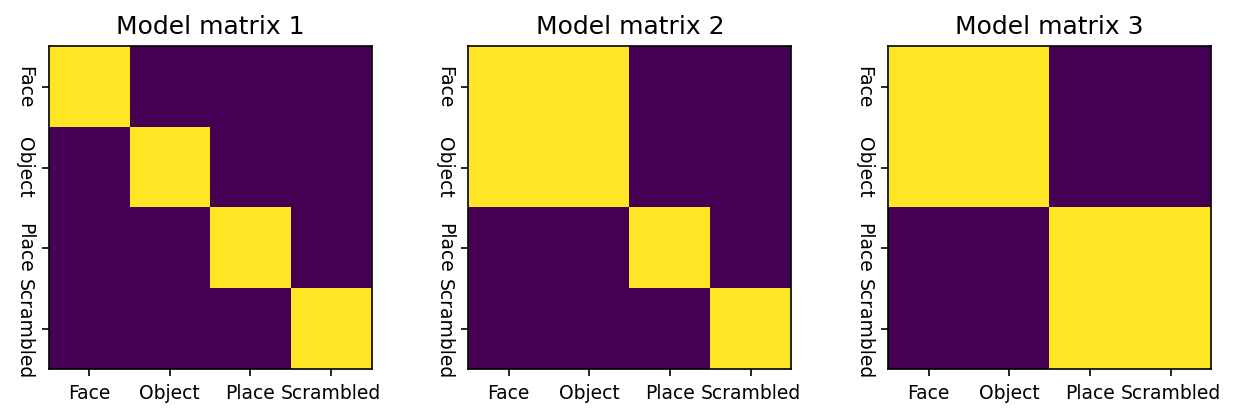

In [29]:
hypothetical_similarity = np.zeros((4,4))
np.fill_diagonal(hypothetical_similarity, 1)

plt.figure(figsize=(10,3), dpi=150)
plt.subplot(131)
plt.title('Model matrix 1')
plt.imshow(hypothetical_similarity)
plt.xticks(np.arange(4), ['Face', 'Object', 'Place', 'Scrambled'], fontsize=9)
plt.yticks(np.arange(4), ['Face', 'Object', 'Place', 'Scrambled'], rotation=270, fontsize=9, va='center')

plt.subplot(132)
plt.title('Model matrix 2')
hypothetical_similarity[0,1] = 1
hypothetical_similarity[1,0] = 1
plt.imshow(hypothetical_similarity)
plt.xticks(np.arange(4), ['Face', 'Object', 'Place', 'Scrambled'], fontsize=9)
plt.yticks(np.arange(4), ['Face', 'Object', 'Place', 'Scrambled'], rotation=270, fontsize=9, va='center')

plt.subplot(133)
plt.title('Model matrix 3')
hypothetical_similarity[2,3] = 1
hypothetical_similarity[3,2] = 1
plt.imshow(hypothetical_similarity)
plt.xticks(np.arange(4), ['Face', 'Object', 'Place', 'Scrambled'], fontsize=9)
plt.yticks(np.arange(4), ['Face', 'Object', 'Place', 'Scrambled'], rotation=270, fontsize=9, va='center')

plt.subplots_adjust(wspace=0.3)

The multi-voxel pattern data can be thought of as a vector present in the voxel space. And the similarity between vectors can be calculated by different similarity measures such as cosine similarity, euclidean distance, etc. In this lab, we will use cosine similarity.

In [30]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

cosine_similarity_matrix  = cosine_similarity(X)

print('Cosine similarity matrix: ', cosine_similarity_matrix.shape)

Cosine similarity matrix:  (32, 32)


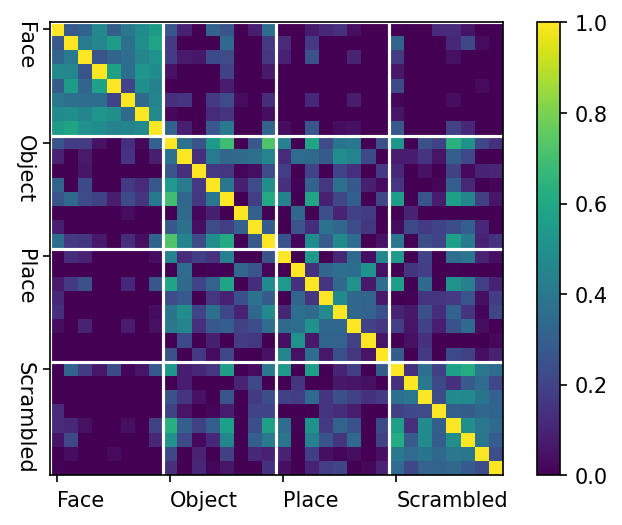

In [31]:
plt.figure(dpi=150)
plt.imshow(cosine_similarity_matrix)
plt.clim(0,1)
plt.colorbar()

plt.xticks([0, 8, 16, 24], ['Face', 'Object', 'Place', 'Scrambled'], ha='left')
plt.yticks([0, 8, 16, 24], ['Face', 'Object', 'Place', 'Scrambled'], rotation=270)

for line in [0, 8, 16, 24]:
    plt.axhline(line-0.5, c='w')
    plt.axvline(line-0.5, c='w')
    
plt.show()

In this lab, MVPA and RSA were conducted using the multi-voxel patterns of the ventral temporal corex. MVPA and RSA are widely used fMRI analysis methods, so if you want to know more or want to use them for your own research, I recommend you to study them more in depth. 

# Recommended reading
- https://dartbrains.org/content/Multivariate_Prediction.html
- https://dartbrains.org/content/RSA.html